In [1]:
# Disable scientific Python notation
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format

# Create a Snowpark Session

In [2]:
# Snowflake Imports
from snowflake.snowpark.session import Session
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
from snowflake.snowpark.functions import sproc, udf

# Other imports
import json
import sys
import re
from cachetools import cached
from sklearn.metrics import mean_absolute_percentage_error
import seaborn as sns

# Reading Snowflake Connection Details
snowflake_connection_cfg = json.loads(open('snowflake_connection.json').read())

# Creating Snowpark Session
session = Session.builder.configs(snowflake_connection_cfg).create()

# Switch Schema
session.use_schema('PYCON_DEMO._0_RAW')

print('Role:     ', session.get_current_role())
print('Warehouse:', session.get_current_warehouse())
print('Database: ', session.get_current_database())
print('Schema:   ', session.get_current_schema())

Role:      "ACCOUNTADMIN"
Warehouse: "COMPUTE_WH"
Database:  "PYCON_DEMO"
Schema:    "_0_RAW"


# Create a Snowpark DataFrame of our Raw Data

In [3]:
snowpark_df = session.table('ECOMMERCE_CUSTOMERS_1M')
snowpark_df.show()

-----------------------------------------------------------------------------------------------------------------------------------------------------------
|"EMAIL"               |"GENDER"  |"MEMBERSHIP_STATUS"  |"MEMBERSHIP_LENGTH"  |"AVG_SESSION_LENGTH"  |"TIME_ON_APP"  |"TIME_ON_WEBSITE"  |"YEARLY_SPENT"  |
-----------------------------------------------------------------------------------------------------------------------------------------------------------
|mfuhbsjnxu@chx4t.com  |MALE      |BRONZE               |0.9                  |9.08                  |91.09          |52.57              |237.39          |
|acofyoh05y@saea2.com  |FEMALE    |GOLD                 |4.49                 |25.06                 |238.5          |NULL               |503.74          |
|hxkryrvffo@tu7k1.com  |MALE      |BRONZE               |1.39                 |7.03                  |89.47          |65.54              |183.11          |
|j7j7aayagi@lg479.com  |MALE      |BASIC                |NULL   

Snowpark Dataframes vs. Pandas DataFrames:

In [4]:
# Data Type
print(f'Type: {type(snowpark_df)}')
print(f'Type: {type(snowpark_df.limit(100).to_pandas())}')

Type: <class 'snowflake.snowpark.table.Table'>
Type: <class 'pandas.core.frame.DataFrame'>


In [5]:
# Local Memory Usage
print(f'Bytes: {sys.getsizeof(snowpark_df)}')
print(f'Bytes: {sys.getsizeof(snowpark_df.limit(100).to_pandas())}')

Bytes: 48
Bytes: 24119


# Data Preparation at Scale

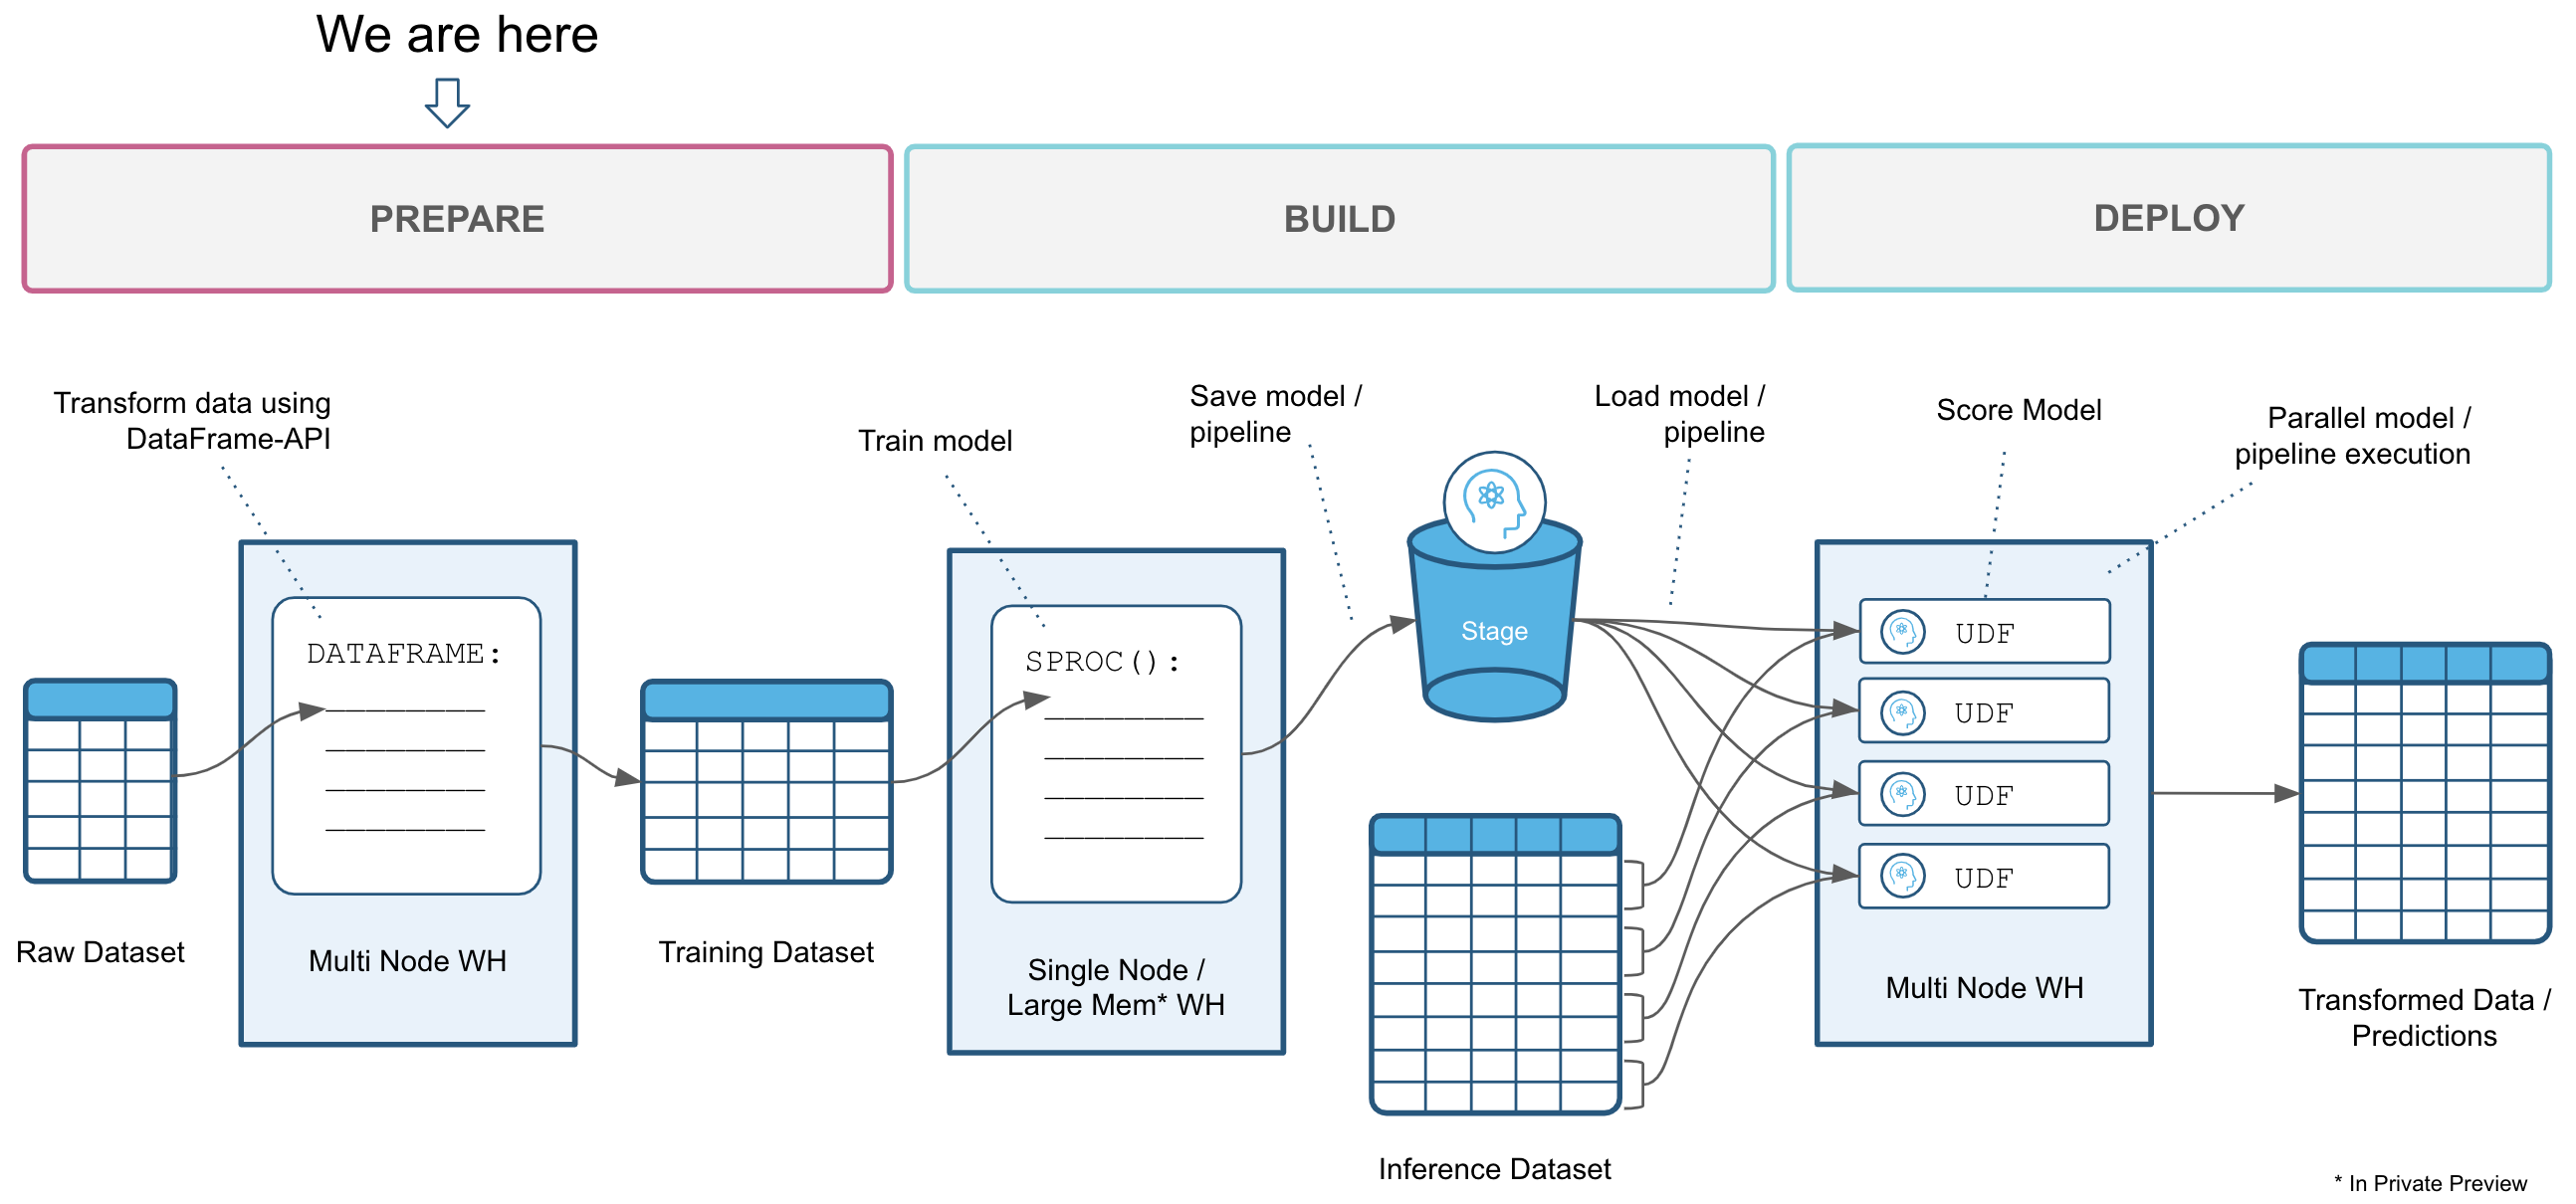

### Describe the dataset

In [6]:
# Snowpark DataFrame has dtypes attributes similar to Pandas DataFrames
snowpark_df.dtypes

[('EMAIL', 'string'),
 ('GENDER', 'string'),
 ('MEMBERSHIP_STATUS', 'string'),
 ('MEMBERSHIP_LENGTH', 'double'),
 ('AVG_SESSION_LENGTH', 'double'),
 ('TIME_ON_APP', 'double'),
 ('TIME_ON_WEBSITE', 'double'),
 ('YEARLY_SPENT', 'double')]

In [7]:
# Get numeric columns
numerical_types = ['double','integer']
numeric_columns = [col[0] for col in snowpark_df.dtypes if col[1] in numerical_types]

# Get categorical columns
categorical_types = ['string']
categorical_columns = [col[0] for col in snowpark_df.dtypes if col[1] in categorical_types]

print('Numeric columns:\t', numeric_columns)
print('Categorical columns:\t', categorical_columns)

# Calculte statistics for our dataset
snowpark_df.describe().sort('SUMMARY').show()

Numeric columns:	 ['MEMBERSHIP_LENGTH', 'AVG_SESSION_LENGTH', 'TIME_ON_APP', 'TIME_ON_WEBSITE', 'YEARLY_SPENT']
Categorical columns:	 ['EMAIL', 'GENDER', 'MEMBERSHIP_STATUS']
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"EMAIL"               |"GENDER"  |"MEMBERSHIP_STATUS"  |"MEMBERSHIP_LENGTH"  |"AVG_SESSION_LENGTH"  |"TIME_ON_APP"       |"TIME_ON_WEBSITE"  |"YEARLY_SPENT"      |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|count      |1000000               |1000000   |959553               |760637.0             |840916.0              |973622.0            |973615.0           |1000000.0           |
|max        |zzzxshzkyt@zgi54.com  |MALE      |SILVER               |10.0                 |40.0                  |400

### Impute missing values on 1 million rows on XSMALL

In [8]:
# Setting Warehouse-size
session.sql('ALTER WAREHOUSE COMPUTE_WH SET WAREHOUSE_SIZE=XSMALL WAIT_FOR_COMPLETION=TRUE').collect()
session.sql('ALTER SESSION SET USE_CACHED_RESULT = FALSE').collect()

[Row(status='Statement executed successfully.')]

In [9]:
# Imputing missing values in numeric columns
for column in numeric_columns:
    snowpark_df = snowpark_df.fillna(snowpark_df[[F.mean(column)]].collect()[0][0], column)
    
# Impute missing values in categorical columns
for column in categorical_columns:
    snowpark_df = snowpark_df.fillna(snowpark_df[[F.mode(column)]].collect()[0][0], column)
    
# Describe resulting dataframe
snowpark_df.describe().sort('SUMMARY').show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"EMAIL"               |"GENDER"  |"MEMBERSHIP_STATUS"  |"MEMBERSHIP_LENGTH"  |"AVG_SESSION_LENGTH"  |"TIME_ON_APP"       |"TIME_ON_WEBSITE"   |"YEARLY_SPENT"      |
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|count      |1000000               |1000000   |1000000              |1000000.0            |1000000.0             |1000000.0           |1000000.0           |1000000.0           |
|max        |zzzxshzkyt@zgi54.com  |MALE      |SILVER               |10.0                 |40.0                  |400.0               |300.0               |750.0               |
|mean       |NULL                  |NULL      |NULL                 |4.336885321119009    |21.35381876429988  

### Impute missing values for 100 million rows (Factor 100X) on 2XLARGE

In [10]:
# Setting Warehouse-size
session.sql('ALTER WAREHOUSE COMPUTE_WH SET WAREHOUSE_SIZE=XXLARGE WAIT_FOR_COMPLETION=TRUE').collect()
session.sql('ALTER SESSION SET USE_CACHED_RESULT = FALSE').collect()

# Grab a bigger dataset with 100 million rows
snowpark_df = session.table('ECOMMERCE_CUSTOMERS_100M')

In [11]:
# Imputing missing values in numeric columns
for column in numeric_columns:
    snowpark_df = snowpark_df.fillna(snowpark_df[[F.mean(column)]].collect()[0][0], column)
    
# Impute missing values in categorical columns
for column in categorical_columns:
    snowpark_df = snowpark_df.fillna(snowpark_df[[F.mode(column)]].collect()[0][0], column)
    
# Describe resulting dataframe
snowpark_df.describe().sort('SUMMARY').show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"SUMMARY"  |"EMAIL"               |"GENDER"   |"MEMBERSHIP_STATUS"  |"MEMBERSHIP_LENGTH"  |"AVG_SESSION_LENGTH"  |"TIME_ON_APP"       |"TIME_ON_WEBSITE"   |"YEARLY_SPENT"      |
----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|count      |100000000             |100000000  |100000000            |100000000.0          |100000000.0           |100000000.0         |100000000.0         |100000000.0         |
|max        |zzzzzz5wqt@k9xyh.com  |MALE       |SILVER               |10.0                 |40.0                  |400.0               |300.0               |750.0               |
|mean       |NULL                  |NULL       |NULL                 |4.3331920241287945   |21.3292104790

### One-Hot-Encoding for 100 million rows

What is One-Hot-Encoding?

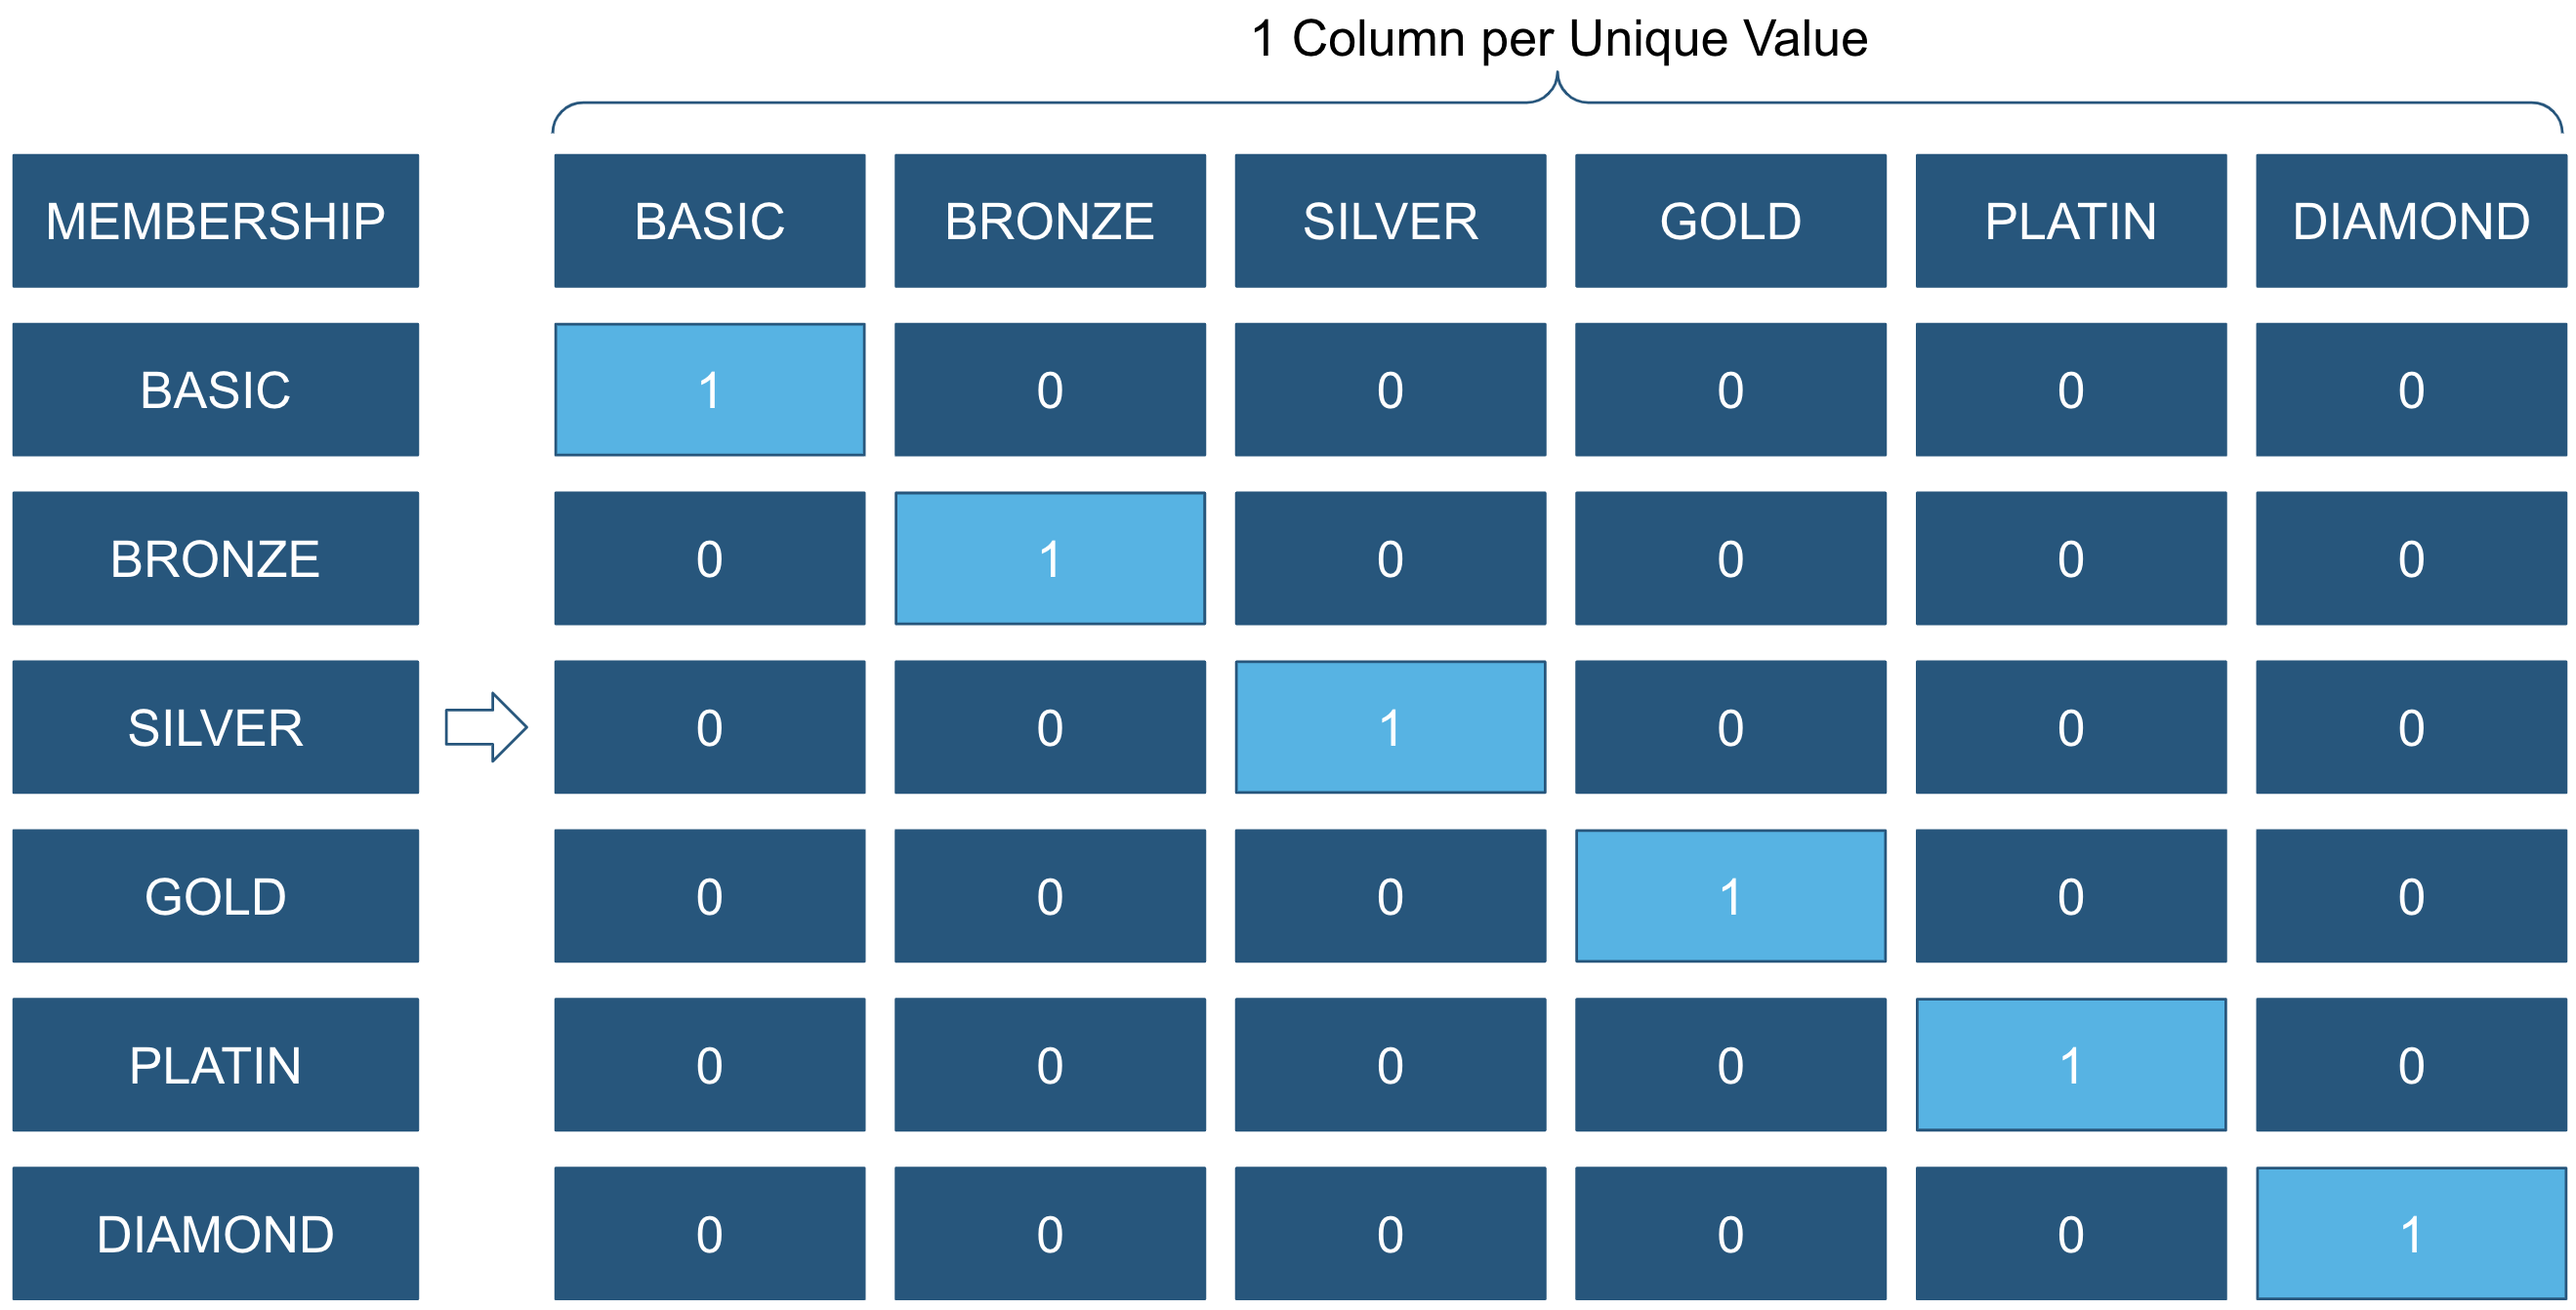

In [12]:
def ohe(df, input_columns):
    for column in input_columns:
        # Get distinct values per column
        distinct_values = [value for value in df.select(column).distinct().collect()]
        # Add transformation
        for distinct_value in distinct_values:
            df = df.with_column(f"{column}_'{distinct_value[0]}'", F.iff(F.col(column) == distinct_value[0], F.lit(1), F.lit(0)))
    return df

snowpark_df_ohe = ohe(snowpark_df, input_columns=['GENDER','MEMBERSHIP_STATUS'])
snowpark_df_ohe = snowpark_df_ohe.to_df([re.sub('[^0-9a-zA-Z_]+', '', col) for col in snowpark_df_ohe.columns])
snowpark_df_ohe.show()

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EMAIL"               |"GENDER"  |"MEMBERSHIP_STATUS"  |"MEMBERSHIP_LENGTH"  |"AVG_SESSION_LENGTH"  |"TIME_ON_APP"  |"TIME_ON_WEBSITE"  |"YEARLY_SPENT"  |"GENDER_FEMALE"  |"GENDER_MALE"  |"MEMBERSHIP_STATUS_DIAMOND"  |"MEMBERSHIP_STATUS_BASIC"  |"MEMBERSHIP_STATUS_SILVER"  |"MEMBERSHIP_STATUS_GOLD"  |"MEMBERSHIP_STATUS_BRONZE"  |"MEMBERSHIP_STATUS_PLATIN"  |
------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

<b><i>SnowML is currently in Private Preview</i></b>

In [13]:
from snowflake.ml.preprocessing import OneHotEncoder
ohe = OneHotEncoder(input_cols=['GENDER','MEMBERSHIP_STATUS'], output_cols=['GENDER','MEMBERSHIP_STATUS'])
ohe.fit(snowpark_df)
snowpark_df = ohe.transform(snowpark_df)
snowpark_df = snowpark_df.to_df([re.sub('[^0-9a-zA-Z_]+', '', col) for col in snowpark_df.columns])
snowpark_df.show()

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EMAIL"               |"GENDER"  |"MEMBERSHIP_STATUS"  |"MEMBERSHIP_LENGTH"  |"AVG_SESSION_LENGTH"  |"TIME_ON_APP"       |"TIME_ON_WEBSITE"  |"YEARLY_SPENT"  |"GENDER_FEMALE"  |"GENDER_MALE"  |"MEMBERSHIP_STATUS_BASIC"  |"MEMBERSHIP_STATUS_BRONZE"  |"MEMBERSHIP_STATUS_DIAMOND"  |"MEMBERSHIP_STATUS_GOLD"  |"MEMBERSHIP_STATUS_PLATIN"  |"MEMBERSHIP_STATUS_SILVER"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Splitting into train/test

In [14]:
train_df, test_df = snowpark_df.random_split(weights=[0.7,0.3])

### Persist the Transformation Results in a new Tables

In [15]:
train_df.write.save_as_table(table_name='PYCON_DEMO._1_ENRICHED.ECOMMERCE_CUSTOMERS_100M_TRAIN', mode='overwrite')
test_df.write.save_as_table(table_name='PYCON_DEMO._1_ENRICHED.ECOMMERCE_CUSTOMERS_100M_TEST', mode='overwrite')

### Resize or Suspend Warehouse to save Costs

In [16]:
# Setting Warehouse-size
session.sql('ALTER WAREHOUSE COMPUTE_WH SET WAREHOUSE_SIZE=XSMALL WAIT_FOR_COMPLETION=TRUE').collect()
session.sql('ALTER SESSION SET USE_CACHED_RESULT = TRUE').collect()

[Row(status='Statement executed successfully.')]

# Model-Training in Snowflake

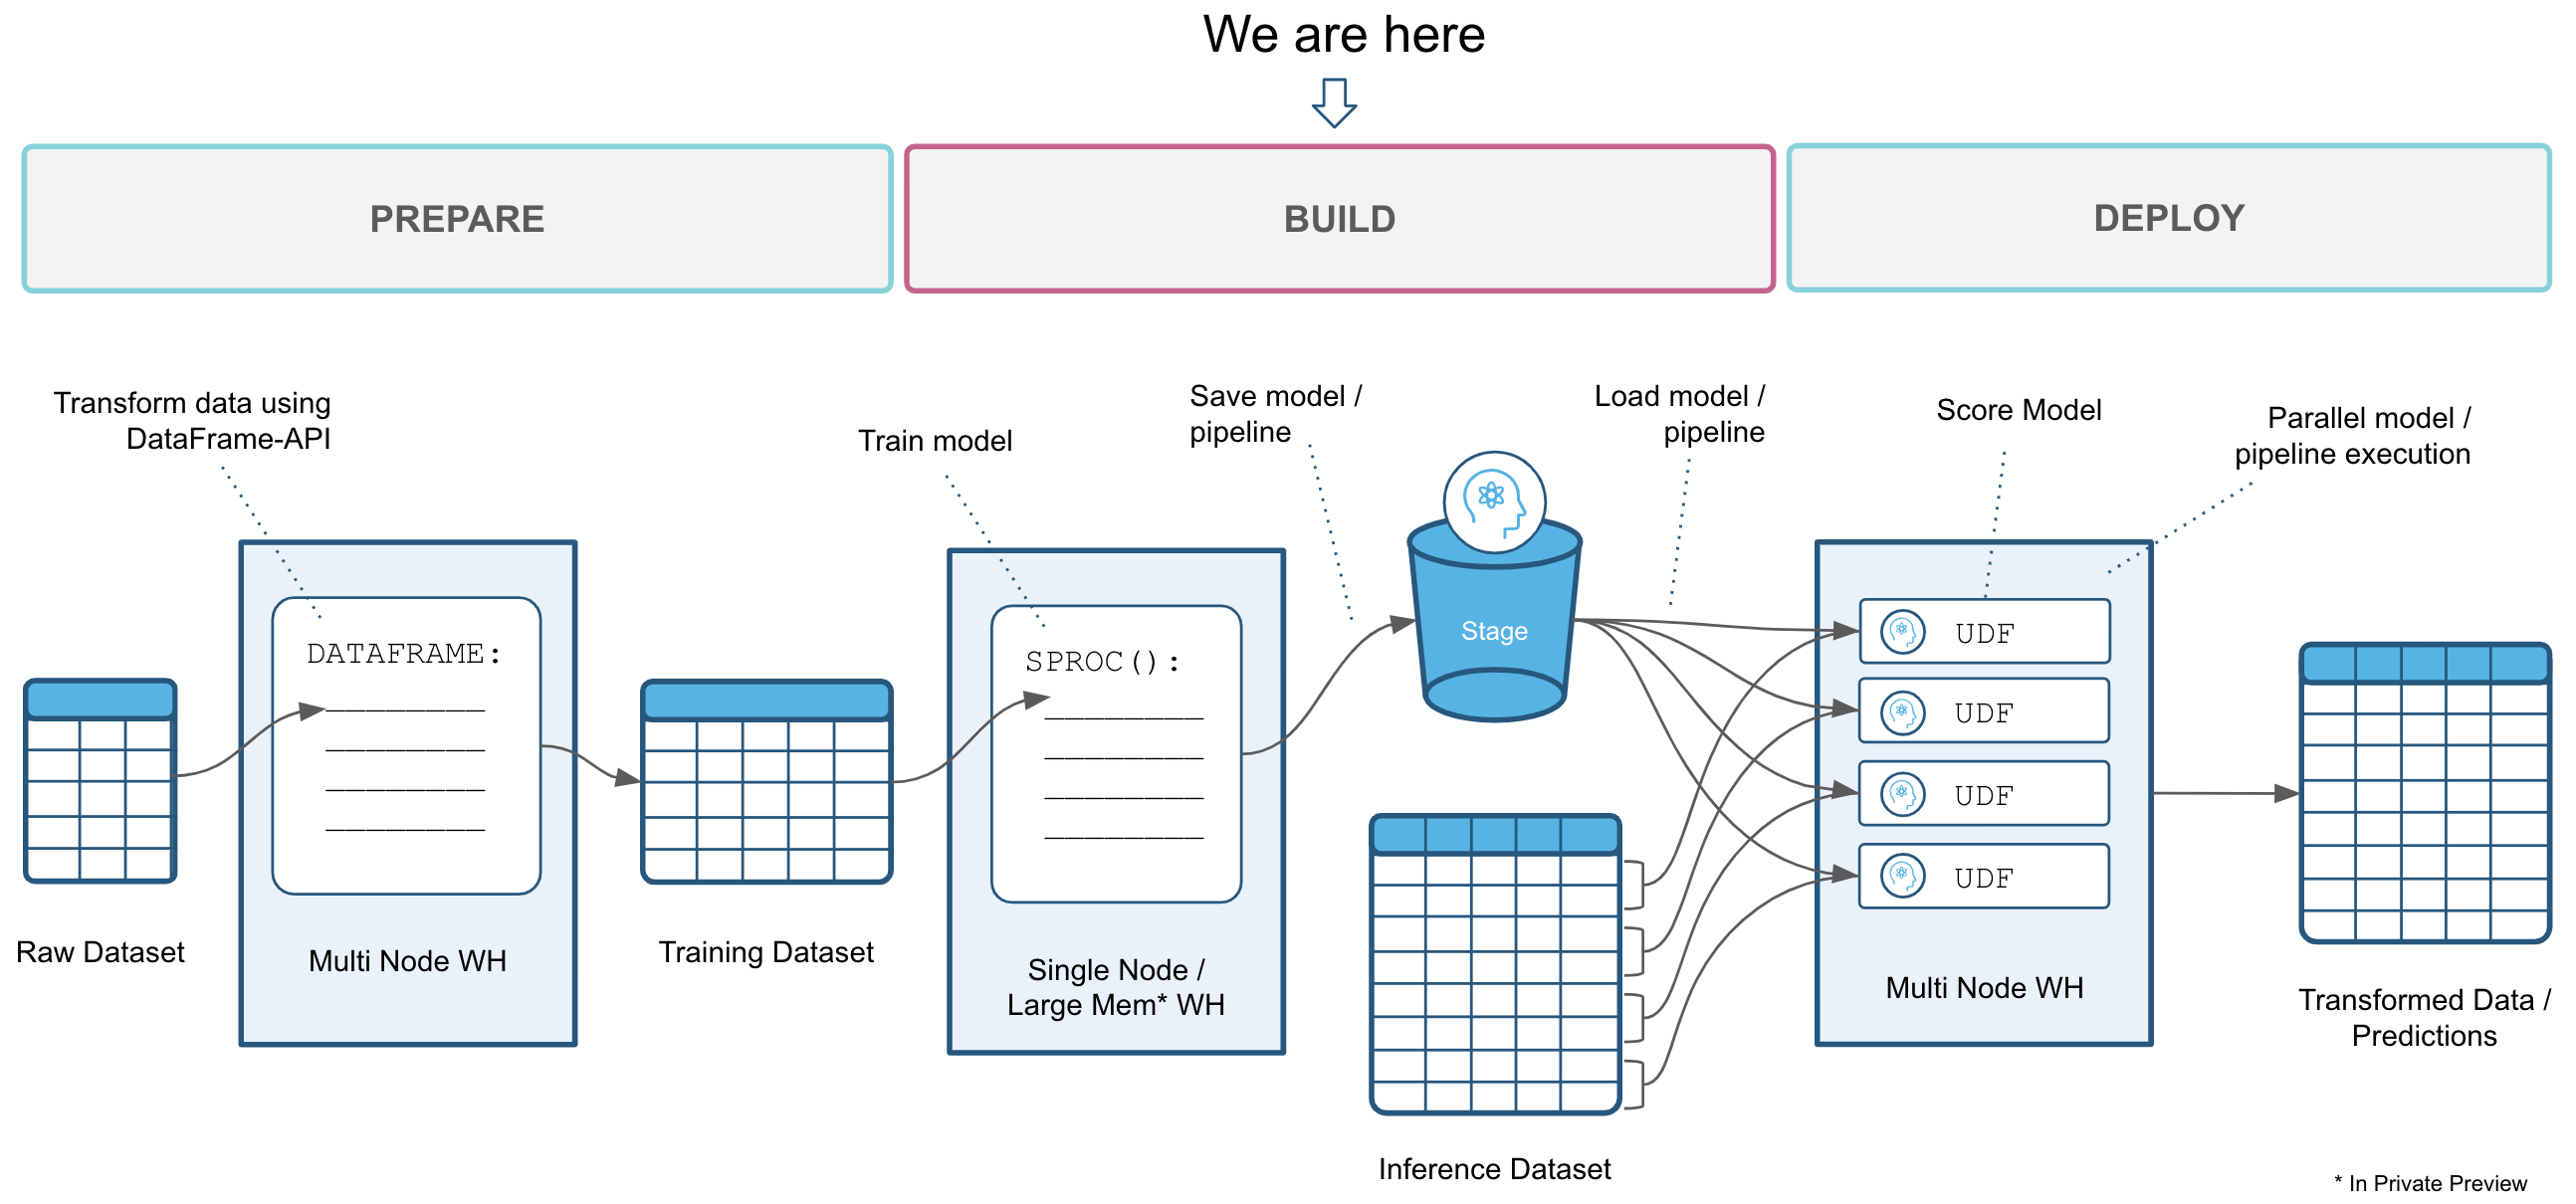

In [17]:
# Switch schema
session.use_schema('PYCON_DEMO._1_ENRICHED')

In [18]:
# Create a Snowflake stage to store functions
session.sql('CREATE OR REPLACE STAGE FUNCTIONS').collect()
# Create a Snowflake stage to store models
session.sql('CREATE OR REPLACE STAGE MODELS').collect()

[Row(status='Stage area MODELS successfully created.')]

In [19]:
# Stored Procedure to train a Random Forest Model
@sproc(name='TRAIN_RF_MODEL', 
       stage_location='@FUNCTIONS', 
       packages=['snowflake-snowpark-python','scikit-learn==1.2.1','joblib','pandas'],
       is_permanent=True, 
       replace=True, 
       session=session)
def train_rf_model(session: Session,
                   training_table: str, 
                   feature_cols: list,
                   target_col: str,
                   model_conf: dict,
                   sample_size: int, 
                   model_stage: str,
                   model_name: str) -> T.Variant:
    
    import joblib
    import io
    from sklearn.ensemble import RandomForestRegressor
    import pandas as pd
    
    # Loading data into pandas dataframe
    local_training_data = session.table(training_table).limit(sample_size).to_pandas()

    # Define features and label
    X = local_training_data[feature_cols]
    y = local_training_data[target_col]

    # Actual model training
    # For standard warehouses you can set the backend to 'loky' and n_jobs=-1 to utilize all 8 available cores for training
    # loky backend will be standard for Snowpark-Optimized warehouses
    with joblib.parallel_backend('loky', n_jobs=-1):
        rf = RandomForestRegressor(
            n_estimators=model_conf['n_estimators'], 
            max_depth=model_conf['max_depth'], 
            random_state=0
        )
        rf.fit(X,y)
    
    # Getting feature importance
    feat_imp_df = pd.DataFrame(rf.feature_importances_, rf.feature_names_in_, columns=['FEATURE_IMPORTANCE'])

    # Dump the model in-stream and save to Snowflake stage
    input_stream = io.BytesIO()
    joblib.dump(rf, input_stream)
    model_path = f'@{model_stage}/{model_name}'
    session._conn._cursor.upload_stream(input_stream, model_path)

    return feat_imp_df.to_dict()

In [20]:
# the local function became a Snowflake Stored Procedure due to the decorator
train_rf_model

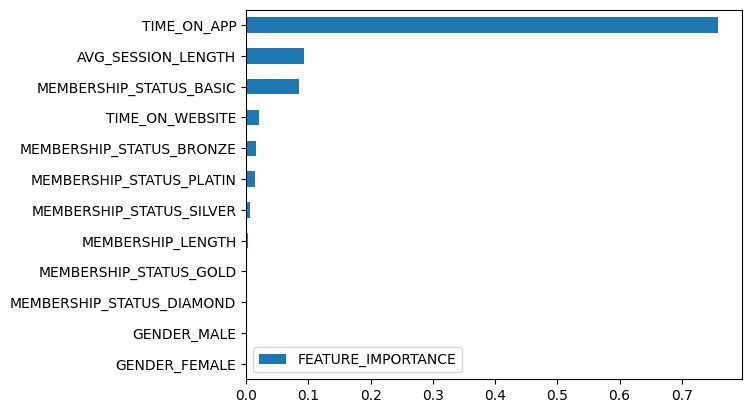

In [21]:
# Running the Stored Procedure to train a model and display coefficients
training_table = 'ECOMMERCE_CUSTOMERS_100M_TRAIN'
feature_cols = [
    "AVG_SESSION_LENGTH", 
    "TIME_ON_APP",
    "TIME_ON_WEBSITE",
    "MEMBERSHIP_LENGTH",
    "GENDER_FEMALE",
    "GENDER_MALE",
    "MEMBERSHIP_STATUS_BASIC",
    "MEMBERSHIP_STATUS_BRONZE",
    "MEMBERSHIP_STATUS_SILVER",
    "MEMBERSHIP_STATUS_GOLD",
    "MEMBERSHIP_STATUS_PLATIN",
    "MEMBERSHIP_STATUS_DIAMOND"
]
target_col = 'YEARLY_SPENT'
model_conf = {
    'n_estimators':100,
    'max_depth':5
}
sample_size = 100000
model_stage = 'MODELS'
model_name = 'my_rf_model.sav'

feat_importance = train_rf_model(
    session, 
    training_table, 
    feature_cols, 
    target_col,
    model_conf,
    sample_size,
    model_stage,
    model_name
)

_ = pd.DataFrame(eval(feat_importance)).sort_values('FEATURE_IMPORTANCE').plot.barh()

In [22]:
# The model is now stored in a Snowflake stage
session.sql('LIST @MODELS').show()

------------------------------------------------------------------------------------------------------
|"name"                  |"size"  |"md5"                             |"last_modified"                |
------------------------------------------------------------------------------------------------------
|models/my_rf_model.sav  |432960  |535e9700a45b63caa908e698f4c5bfa9  |Sun, 16 Apr 2023 23:54:51 GMT  |
------------------------------------------------------------------------------------------------------



# Model-Inferencing in Snowflake

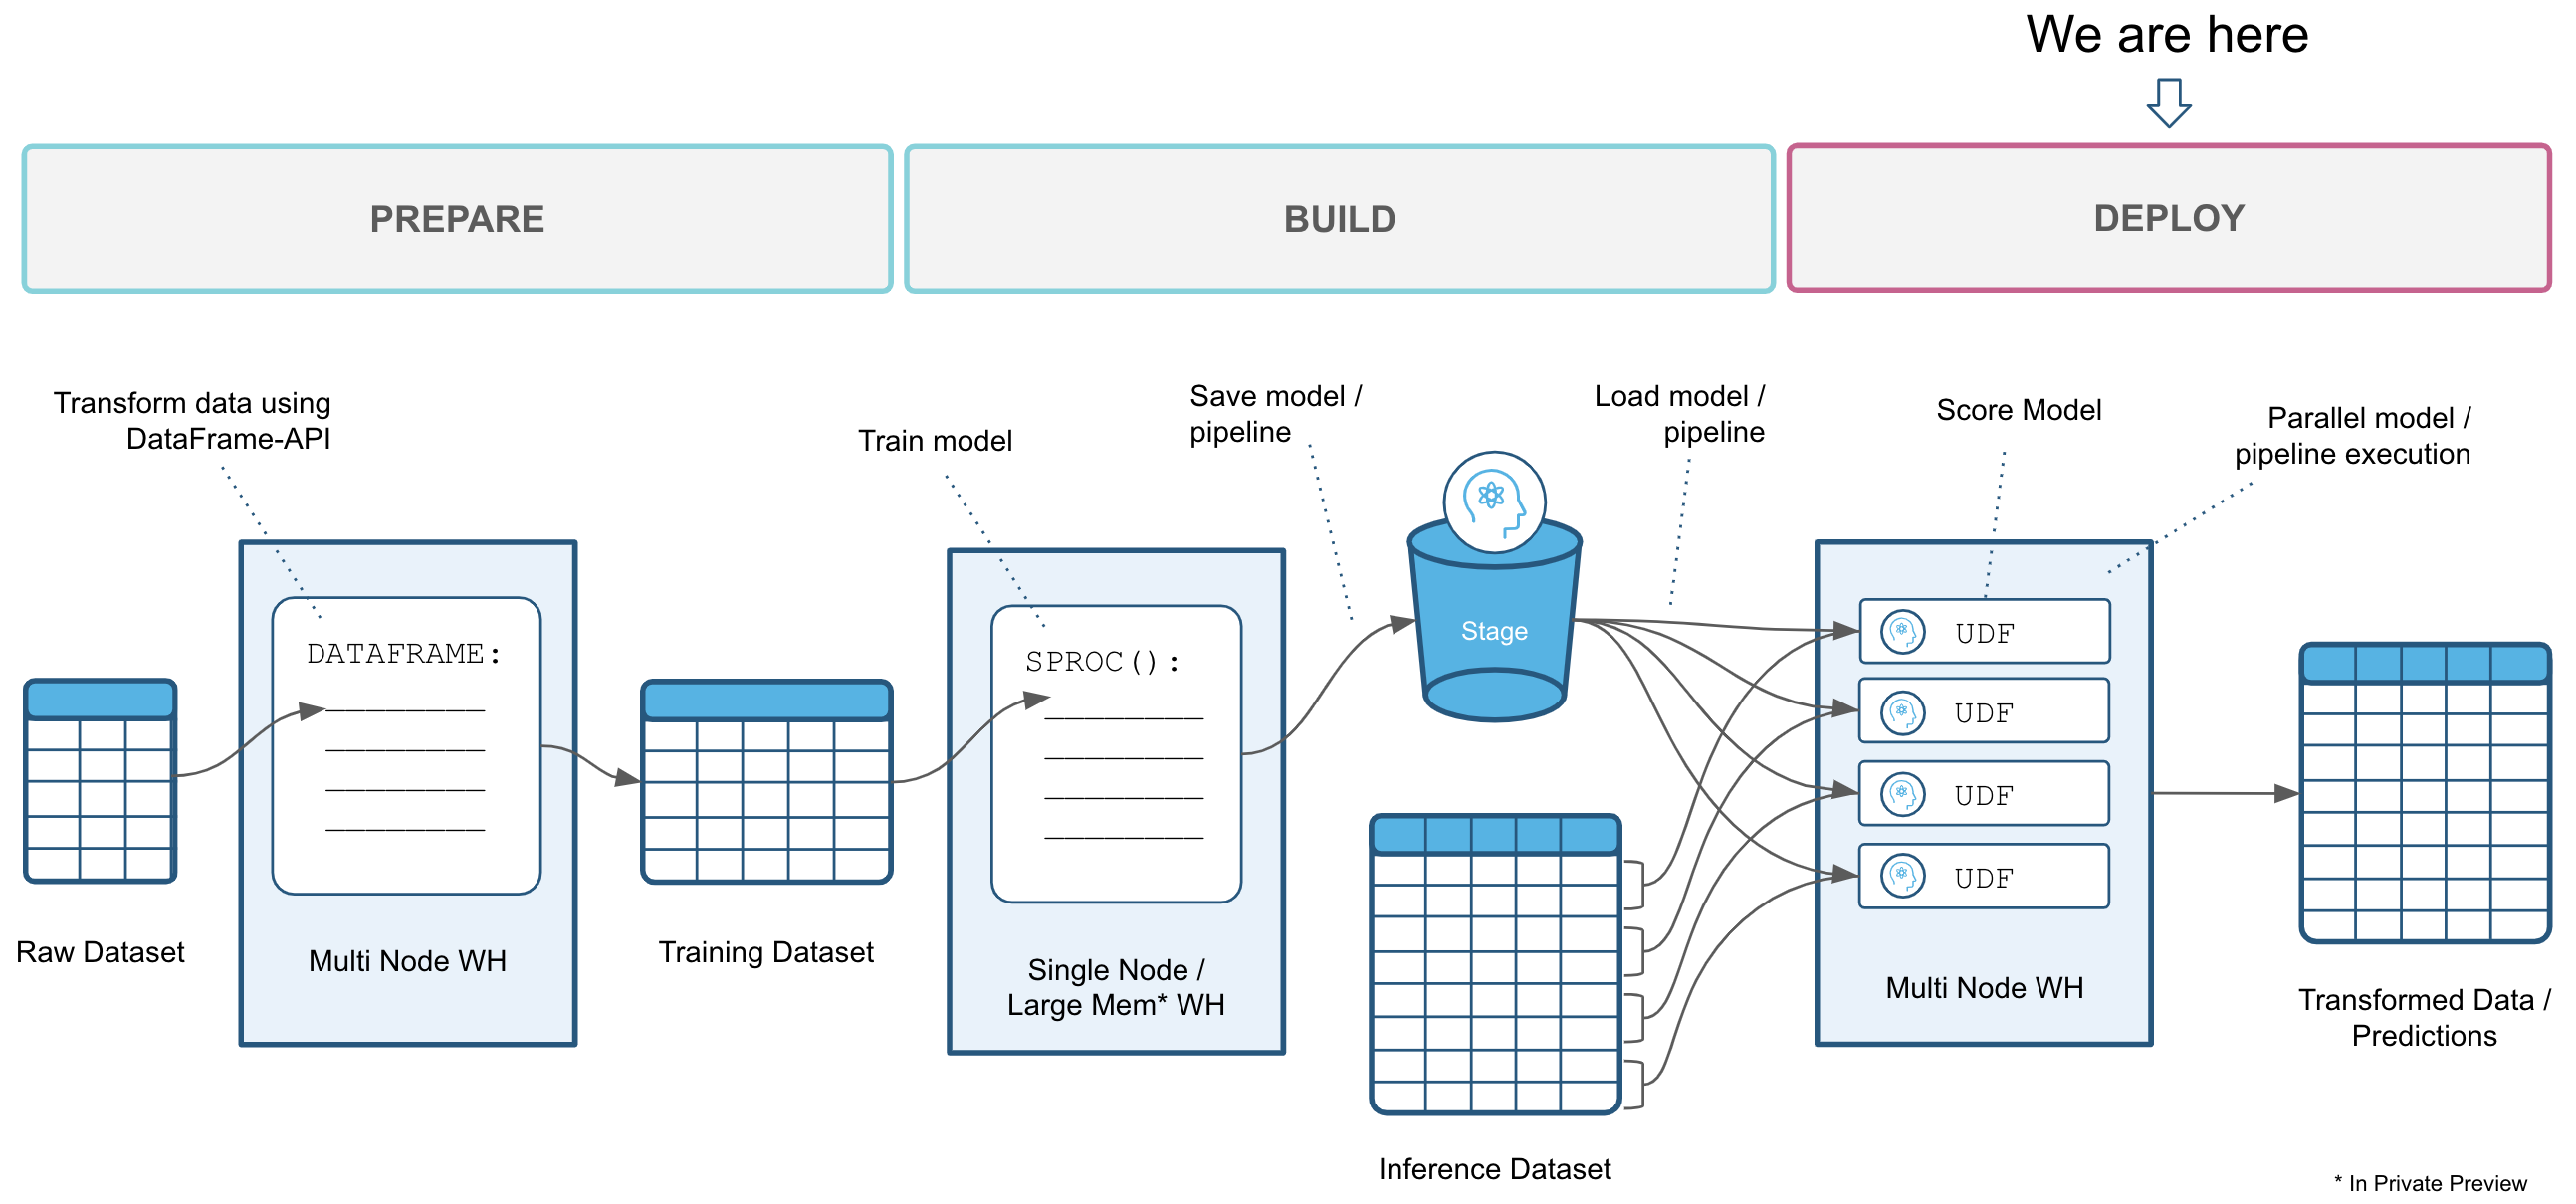

In [23]:
# the cached decorator makes sure that we only load the model once per worker
@cached(cache={})
def load_model(model_path: str) -> object:
    from joblib import load
    model = load(model_path)
    return model

# This is a vectorized UDF that scores rows in batches which is much more efficient than row-by-row scoring
@udf(name="SCORE_RF_MODEL", 
     stage_location='@FUNCTIONS', 
     packages=['scikit-learn==1.2.1','pandas','joblib','cachetools'],
     imports=['@MODELS/my_rf_model.sav'],
     max_batch_size=10000,
     input_types=[T.FloatType()]*12,
     return_type = T.FloatType(),
     is_permanent=True, 
     replace=True,
     session=session)
def score_rf_model(df: pd.DataFrame) -> pd.Series:
    import os
    import sys
    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]
    model_name = 'my_rf_model.sav'
    model = load_model(import_dir+model_name)
    return model.predict(df)

In [24]:
# the local function became a Snowflake User-Defined-Function due to the decorator
score_rf_model

In [25]:
# Depending on the warehouse-size, we will spawn multiple Python workers to parallelize model-inference
# Setting Warehouse-size
session.sql('ALTER WAREHOUSE COMPUTE_WH SET WAREHOUSE_SIZE=XLARGE WAIT_FOR_COMPLETION=TRUE').collect()

# Feel free to increase the sample-size
sample_size = 10000000

test_df_scored = session.table('PYCON_DEMO._1_ENRICHED.ECOMMERCE_CUSTOMERS_100M_TEST').limit(sample_size)
test_df_scored = test_df_scored.with_column('PREDICTED_SPEND', score_rf_model(*feature_cols))

# Save scored data
test_df_scored.write.save_as_table(table_name='PYCON_DEMO._2_MODELLED.ECOMMERCE_CUSTOMERS_100M_SCORED', mode='overwrite')

# View scored data
session.table('PYCON_DEMO._2_MODELLED.ECOMMERCE_CUSTOMERS_100M_SCORED').show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"EMAIL"               |"GENDER"  |"MEMBERSHIP_STATUS"  |"MEMBERSHIP_LENGTH"  |"AVG_SESSION_LENGTH"  |"TIME_ON_APP"  |"TIME_ON_WEBSITE"  |"YEARLY_SPENT"  |"GENDER_FEMALE"  |"GENDER_MALE"  |"MEMBERSHIP_STATUS_BASIC"  |"MEMBERSHIP_STATUS_BRONZE"  |"MEMBERSHIP_STATUS_DIAMOND"  |"MEMBERSHIP_STATUS_GOLD"  |"MEMBERSHIP_STATUS_PLATIN"  |"MEMBERSHIP_STATUS_SILVER"  |"PREDICTED_SPEND"  |
--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

## Evaluate Model

   YEARLY_SPENT  PREDICTED_SPEND
0      463.0100         445.9728
1      355.3500         360.0802
2      345.3100         325.0921
3      266.6700         277.7429
4      583.0000         598.3691
Mean absolute percentage error: 0.3122201287002478


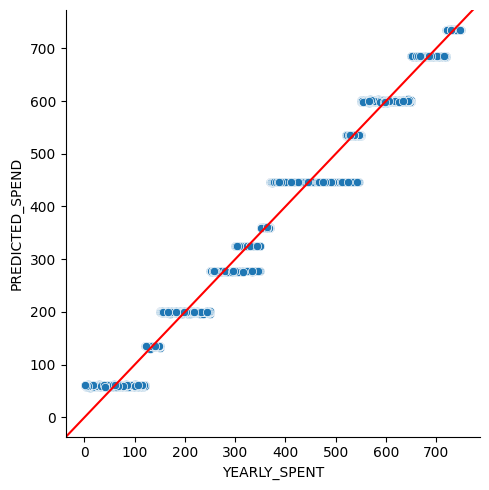

In [26]:
df = session.table('PYCON_DEMO._2_MODELLED.ECOMMERCE_CUSTOMERS_100M_SCORED')['YEARLY_SPENT','PREDICTED_SPEND'].limit(10000).to_pandas().astype("float64")
print(df.head())
print(f"Mean absolute percentage error: {mean_absolute_percentage_error(df['YEARLY_SPENT'],df['PREDICTED_SPEND'])}")
g = sns.relplot(data=df, x="YEARLY_SPENT", y="PREDICTED_SPEND", kind="scatter")
g.ax.axline((0,0), slope=1, color="r") 